In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import copy 
from sklearn.linear_model import LinearRegression
    

In [32]:
df = pd.read_csv('SeoulBikeData.csv')
df = df[df['Hour']==12]
df = df.drop(['Date','Holiday','Seasons','Hour'],axis=1)
df['FunctioningDay'] = (df['FunctioningDay']=='Yes').astype(int)
cols = list(df.columns)
print(cols)
df.head()

['Rented_Bike_Count', 'Temperature', 'Humidity', 'Wind_speed', 'Visibility', 'Dew_point temperature', 'SolarRadiation', 'Rainfall', 'Snowfall', 'FunctioningDay']


,Rented_Bike_Count,Temperature,Humidity,Wind_speed,Visibility,Dew_point temperature,SolarRadiation,Rainfall,Snowfall,FunctioningDay
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


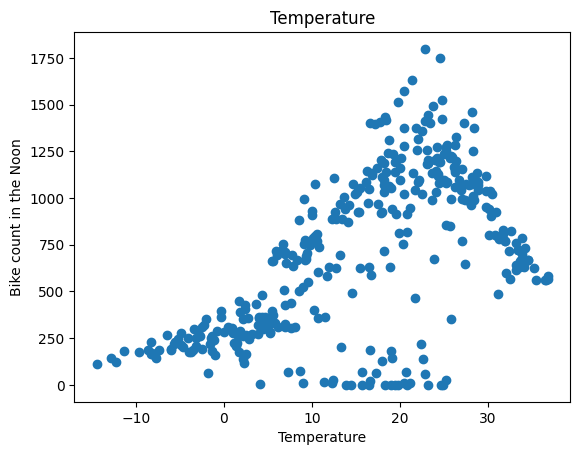

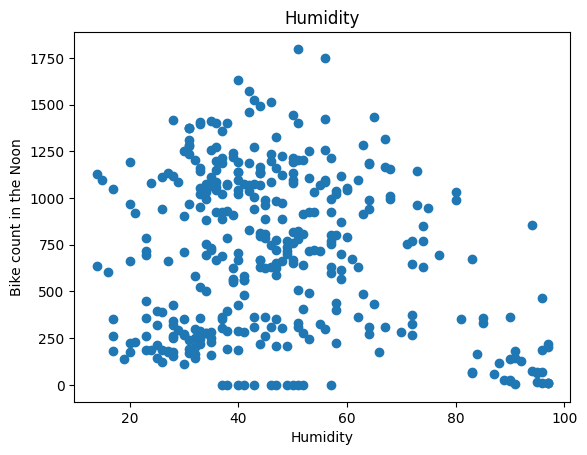

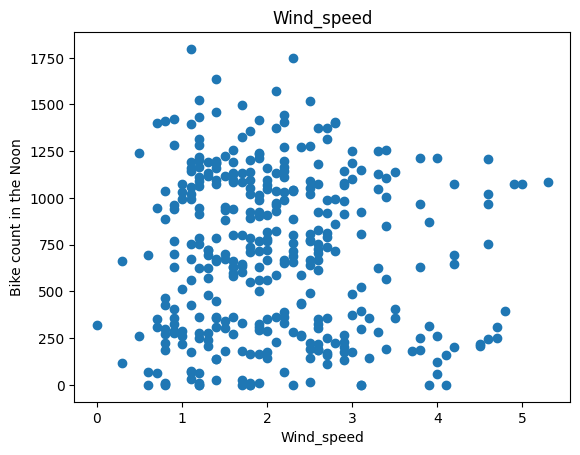

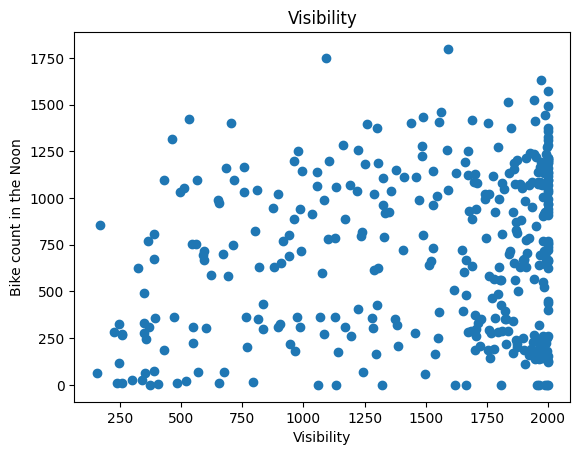

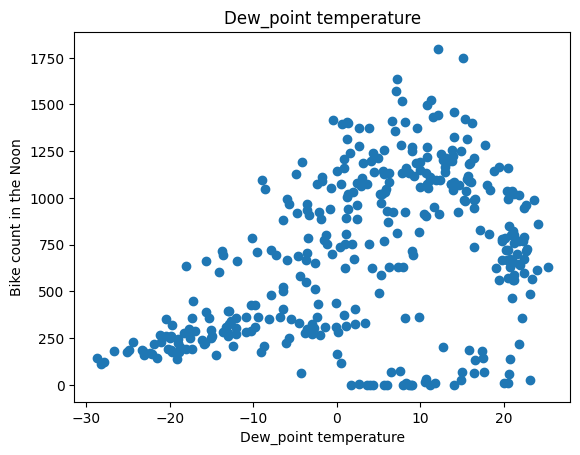

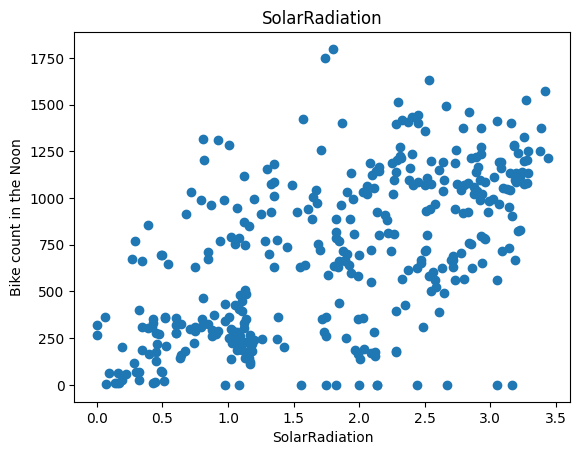

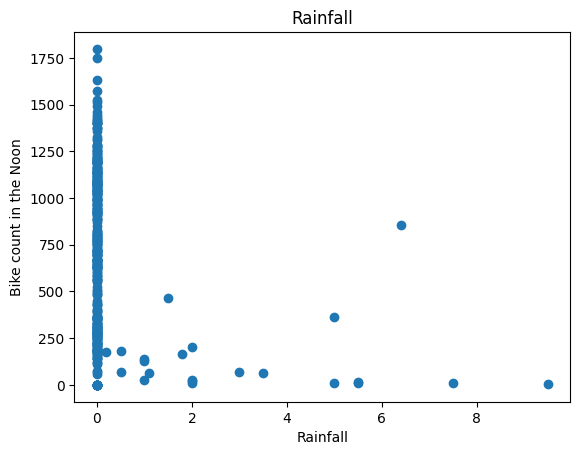

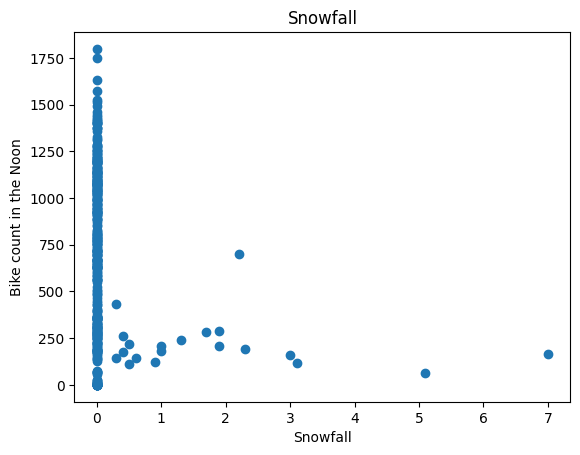

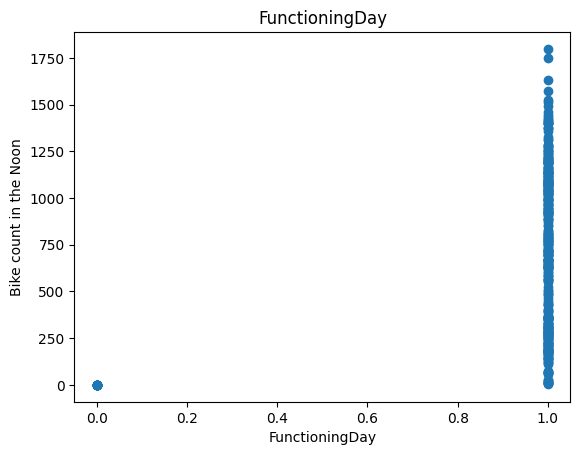

In [33]:
for label in cols[1:]:
    plt.scatter(df[label],df['Rented_Bike_Count'])
    plt.title(label)
    plt.ylabel('Bike count in the Noon')
    plt.xlabel(label)
    plt.show()

# Dropping the feature that are not linear to the "Rented_Bike_Count"	

In [34]:
df = df.drop(['Wind_speed','Visibility','FunctioningDay'],axis=1)
df.head()

,Rented_Bike_Count,Temperature,Humidity,Dew_point temperature,SolarRadiation,Rainfall,Snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [35]:
train, valid , test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

C:\Users\dhurk\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [36]:
def getXy(dataframe, ylabel, xlabel=None):
    dataframe = dataframe.copy()
    if xlabel is None:
        X = dataframe.drop(columns=[ylabel]).values  # Drop target column to get features
    else:
        missing_cols = [col for col in xlabel if col not in dataframe.columns]
        if missing_cols:
            raise KeyError(f"Missing columns: {missing_cols}")

        X = dataframe[xlabel].values if len(xlabel) > 1 else dataframe[xlabel[0]].values.reshape(-1, 1)

    y = dataframe[ylabel].values.reshape(-1, 1)
    data = np.hstack((X, y))
    return data, X, y

In [37]:
train, train_X, train_y = getXy(train,"Rented_Bike_Count",xlabel=['Temperature'])
valid, valid_X, valid_y = getXy(valid,"Rented_Bike_Count",xlabel=['Temperature'])
test, test_X, test_y = getXy(test,"Rented_Bike_Count",xlabel=['Temperature'])

In [38]:
regModel = LinearRegression()
regModel.fit(train_X,train_y)

LinearRegression()

In [39]:
regModel.score(test_X,test_y)

0.2964170153562359

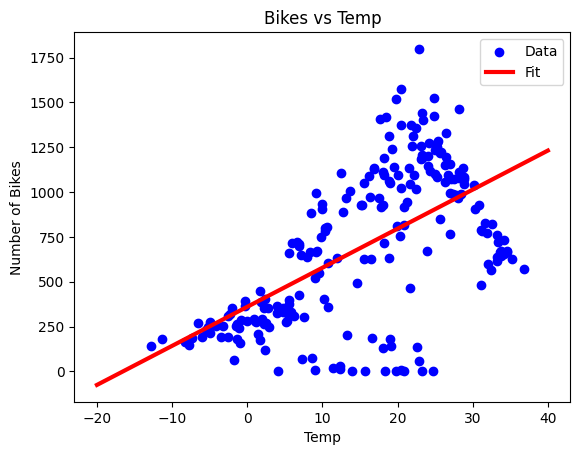

In [40]:
plt.scatter(train_X,train_y,label='Data',color='blue')
x = np.linspace(-20,40,100)
plt.plot(x,regModel.predict(np.array(x).reshape(-1,1)),label='Fit',color='red',linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of Bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Regression

In [41]:
train, valid , test = np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])
train, train_X, train_y = getXy(train,"Rented_Bike_Count",xlabel=df.columns[1:])
valid, valid_X, valid_y = getXy(valid,"Rented_Bike_Count",xlabel=df.columns[1:])
test, test_X, test_y = getXy(test,"Rented_Bike_Count",xlabel=df.columns[1:])
regModel_multi = LinearRegression()
regModel_multi.fit(train_X, train_y)

C:\Users\dhurk\miniconda3\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


LinearRegression()

In [42]:
regModel_multi.score(test_X,test_y)

0.29468429607598945